## Set Up

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy 
import json
import matplotlib.pyplot as plt

%matplotlib inline

### Set Up Twitter's API




In [2]:
consumer_secret = ''
access_token = ''
consumer_key = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Gathering Data

### Load/Read CSV Fils

> Load the twitter-archive-enhanced.csv file into archive_df

In [3]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### s

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' 

response = requests.get(url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
img_df = pd.read_csv('image_predictions.tsv', sep='\t')
img_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Get Tweets by Twitter's API

> Get Tweet by its id (id: from archive_df) with all its data, and store it into tweets_found list. If the tweet not found the id will store in tweets_not_found list.

In [5]:
def load_tweets():
    tweets_found = []
    tweets_not_found = []
    nm = 0
    for tweet_id in archive_df['tweet_id']:
        try:
            nm += 1
            print(str(nm), end =" ") 
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json_content = tweet._json        

            tweets_found.append(json_content)
        except Exception as e:
            tweets_not_found.append(tweet_id)
            
    print('Number of Tweets found: {}.\nNumber of Tweets not found: {}.'.format(len(tweets_found), len(tweets_not_found)))
    return tweets_found

# tweets_found = load_tweets()

### Write Tweets Found into JSON File

> After I store tweets in tweets_found list I will write those tweets into json file tweet_json.txt.

> Based on JSON format:
>* After I open tweet_json.txt file, I write " [ ".
>* Then I write the tweet and comma with new line (tweet by tweet).
>* If tweet is the last tweet I don't write comma. 
>* In the last I write " ] ".

In [6]:
def write_tweets():
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        outfile.write('[')
        for tweet in tweets_found:
            json.dump(tweet, outfile)
            
            if tweet is not tweets_found[-1]:
                outfile.write(',\n')
            else:
                outfile.write('')
        outfile.write(']')
        
# write_tweets()

### Read My tweet_json File
> Read tweets and store into "tweets".

In [7]:
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    tweets = json.load(json_file)

### Number of Retweeted Tweets



In [8]:
nm = 0
index = 0
retweeted_status = []

for tweet in tweets:
    if 'retweeted_status' in dict(tweet):
        nm += 1
        retweeted_status.append(True)
    else :
        retweeted_status.append(False)
    index += 1
nm

166

### Create New DF for Tweets

> After we write the tweets into tweet_json.txt and read those tweets then remove retweeted tweets, now I will store "tweets" into dataframe "tweets_df".

In [9]:
tweets_dict = []

for tweet in tweets:
    tweets_dict.append({'tweet_id': tweet['id'],
                         'favorite_count': tweet['favorite_count'],
                         'retweet_count': tweet['retweet_count'],
                        })

tweets_df = pd.DataFrame(tweets_dict, columns = ['tweet_id', 'favorite_count','retweet_count'])
tweets_df["retweeted_status"] = retweeted_status # False not retweeted, True is retweeted
tweets_df.head(5)

,tweet_id,favorite_count,retweet_count,retweeted_status
0,892420643555336193,37474,8162,False
1,892177421306343426,32209,6040,False
2,891815181378084864,24279,3998,False
3,891689557279858688,40796,8314,False
4,891327558926688256,39013,9011,False


## Assessing Data

### 1. Assess | archive_df

In [10]:
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
archive_df.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


* Missing Valuse (NaNs and None)

In [12]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
sum(archive_df['tweet_id'].duplicated())

0

In [14]:
archive_df['retweeted_status_id'].count()

181

* timestamp and retweeted_status_timestamp are object (not DateTime)

In [15]:
archive_df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [16]:
archive_df['name'].value_counts()

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
Oliver       11
Lola         10
Tucker       10
Penny        10
Winston       9
Bo            9
Sadie         8
the           8
Toby          7
Bailey        7
Daisy         7
an            7
Buddy         7
Jack          6
Scout         6
Bella         6
Stanley       6
Dave          6
Jax           6
Rusty         6
Oscar         6
Milo          6
Leo           6
Koda          6
Finn          5
           ... 
Mac           1
Norman        1
Eriq          1
Andy          1
Gustaf        1
Lenox         1
my            1
Ronnie        1
Jersey        1
Tuco          1
Ziva          1
Sailor        1
Mya           1
Bluebert      1
Dobby         1
Raphael       1
Geno          1
Marty         1
Rontu         1
Willem        1
Hermione      1
Jim           1
Obi           1
Jerome        1
Bowie         1
Tuck          1
Florence      1
Cilantro      1
Kanu          1
Ralf          1
Name: name, Length: 957,

In [17]:
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [18]:
archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [19]:
archive_df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [20]:
archive_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [21]:
archive_df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [22]:
archive_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [23]:
len(archive_df[archive_df.retweeted_status_id.isnull() == False])


181

### 2. Assess | tweets_df

In [24]:
tweets_df.head(5)

,tweet_id,favorite_count,retweet_count,retweeted_status
0,892420643555336193,37474,8162,False
1,892177421306343426,32209,6040,False
2,891815181378084864,24279,3998,False
3,891689557279858688,40796,8314,False
4,891327558926688256,39013,9011,False


In [25]:
tweets_df.tail(5)

,tweet_id,favorite_count,retweet_count,retweeted_status
2330,666049248165822465,104,41,False
2331,666044226329800704,288,135,False
2332,666033412701032449,120,43,False
2333,666029285002620928,124,46,False
2334,666020888022790149,2498,492,False


In [26]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 4 columns):
tweet_id            2335 non-null int64
favorite_count      2335 non-null int64
retweet_count       2335 non-null int64
retweeted_status    2335 non-null bool
dtypes: bool(1), int64(3)
memory usage: 57.1 KB


In [27]:
sum(tweets_df['tweet_id'].duplicated())

0

In [28]:
tweets_df['favorite_count'].value_counts()

0        166
2553       4
2138       4
1258       3
3495       3
161        3
242        3
2730       3
2518       3
2246       3
737        3
557        2
328        2
326        2
1571       2
1119       2
748        2
2302       2
5476       2
2223       2
952        2
758        2
1971       2
26967      2
2882       2
3519       2
1103       2
2393       2
4442       2
354        2
        ... 
6780       1
2654       1
4729       1
629        1
11684      1
6714       1
2620       1
2624       1
45633      1
12867      1
41541      1
10822      1
29255      1
6728       1
8783       1
149        1
21075      1
21079      1
2519       1
23134      1
2658       1
586        1
6758       1
2664       1
912        1
17339      1
623        1
625        1
2674       1
20525      1
Name: favorite_count, Length: 1985, dtype: int64

In [29]:
tweets_df['retweet_count'].value_counts()


372      5
88       5
567      4
55       4
500      4
523      4
475      4
463      4
1233     4
545      4
105      4
399      4
57       4
1082     4
228      4
131      4
43       4
692      4
294      4
3644     4
243      4
772      4
569      4
232      4
46       4
1031     4
370      3
1039     3
1120     3
6210     3
        ..
4149     1
18486    1
1247     1
2104     1
3294     1
9437     1
63       1
2112     1
456      1
1243     1
4139     1
41       1
2060     1
39       1
6158     1
2064     1
53       1
19       1
4119     1
25       1
8219     1
29       1
31       1
33       1
34850    1
3298     1
6180     1
4133     1
2086     1
2092     1
Name: retweet_count, Length: 1706, dtype: int64

### 3. Assess | img_df

In [30]:
img_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [31]:
img_df.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [32]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [33]:
sum(img_df["tweet_id"].duplicated())

0

In [34]:
sum(img_df["jpg_url"].duplicated())

66

In [35]:
img_df['img_num'].value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [36]:
img_df['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
beagle                        18
teddy                         18
Shetland_sheepdog             18
Eskimo_dog                    18
Maltese_dog                   18
Rottweiler                    17
Lakeland_terrier              17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

In [37]:
img_df['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [38]:
img_df['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
French_bulldog                     41
Chesapeake_Bay_retriever           41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
Pembroke                           27
Eskimo_dog                         27
collie                             27
kuvasz                             26
Italian_greyhound                  22
American_Staffordshire_terrier     21
Pekinese                           21
toy_terrier                        20
Samoyed                            20
chow                               20
miniature_pinscher                 20
malinois                           20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [39]:
img_df['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [40]:
img_df['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
Staffordshire_bullterrier         32
chow                              32
cocker_spaniel                    31
beagle                            31
toy_poodle                        29
Pomeranian                        29
Pekinese                          29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Boston_bull                       17
Shetland_sheepdog                 17
d

In [41]:
img_df['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

### Quality Issues
* #### archive_df

    * timestamp and retweeted_status_timestamp are object type instead of datetime.
    * source is HTML format.
    * There are records have more than one dog stage.
    * name has missing values with "None" instead of NaN.
    * doggo, floofer, pupper, and puppo have missing values with "None" instead of NaN
    * There are many columns in this dataframe making it hard to read, and some will not be needed for analysis. 

* #### tweets_df
    * There are 166 retweeted. Keep only original tweets.


* #### img_df
    * There are 2075 images, but archive_df contain 2335 tweets. there are 260 missing (maybe some of tweets doesn't contain image).
    * There are 66 images are duplicated.


### Tidiness Issues
* #### archive_df
    * doggo, floofer, pupper, and puppo are unique columns instead one column "dog_stage"
    * Split timestamp into day, month and year (3 columns).

* #### tweets_df
    * twitter2 data should be combined with the twitter1 data since they are information about the same tweet

* #### img_df
    * images data could be combined with the twitter1 data as well since it is all information about 1 tweet
    

## Cleaning Data

### Set Up

In [42]:
archive_clean_df = archive_df.copy()
tweets_clean_df = tweets_df.copy()
img_clean_df = img_df.copy()

In [43]:
img_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Quality Issues
### 1. archive_df

* #### Issue 1.1: 

### Define


Replace all values in timestamp and retweeted_status_timestamp to datetime type instead of object type



### Code

In [44]:
archive_clean_df['timestamp'] = pd.to_datetime(archive_clean_df['timestamp'])
archive_clean_df['retweeted_status_timestamp'] = pd.to_datetime(archive_clean_df['retweeted_status_timestamp'])

### Test

In [45]:
archive_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime

* #### Issue 1.2: 

### Define


Replace all values in source from HTML format to text



### Code

In [46]:
archive_clean_df["source"] = archive_clean_df["source"].str.replace(r'<(?:a\b[^>]*>|/a>)', '')

### Test

In [47]:
archive_clean_df["source"].value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

* #### Issue 1.3: 

### Define

There are records have more than one dog stage like doggo and pupper together, I should check and set one value because in tidiness issues I will meagre those columns to one column.




### Code

In [48]:
print('doggo with floofer:', len(archive_clean_df[(archive_clean_df.doggo != 'None') & (archive_clean_df.floofer != 'None')]))
print('doggo with pupper:', len(archive_clean_df[(archive_clean_df.doggo != 'None') & (archive_clean_df.pupper != 'None')]))
print('doggo with puppo:', len(archive_clean_df[(archive_clean_df.doggo != 'None') & (archive_clean_df.puppo != 'None')]))

# More Check...
print('floofer with pupper:', len(archive_clean_df[(archive_clean_df.floofer != 'None') & (archive_clean_df.pupper != 'None')]))
print('floofer with puppo:', len(archive_clean_df[(archive_clean_df.floofer != 'None') & (archive_clean_df.puppo != 'None')]))
print('pupper with puppo:', len(archive_clean_df[(archive_clean_df.pupper != 'None') & (archive_clean_df.puppo != 'None')]))

doggo with floofer: 1
doggo with pupper: 12
doggo with puppo: 1
floofer with pupper: 0
floofer with puppo: 0
pupper with puppo: 0


doggo with pupper are 12 records. I will set pupper None because pupper is small doggo. 

In [49]:
archive_clean_df.doggo.loc[(archive_clean_df.doggo != 'None') & (archive_clean_df.floofer != 'None')] = 'None'
archive_clean_df.pupper.loc[(archive_clean_df.doggo != 'None') & (archive_clean_df.pupper != 'None')] = 'None'
archive_clean_df.doggo.loc[(archive_clean_df.doggo != 'None') & (archive_clean_df.puppo != 'None')] = 'None'

c:\users\al_ya\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Test

In [50]:
print('doggo with floofer:', len(archive_clean_df[(archive_clean_df.doggo != 'None') & (archive_clean_df.floofer != 'None')]))
print('doggo with pupper:', len(archive_clean_df[(archive_clean_df.doggo != 'None') & (archive_clean_df.pupper != 'None')]))
print('doggo with puppo:', len(archive_clean_df[(archive_clean_df.doggo != 'None') & (archive_clean_df.puppo != 'None')]))

doggo with floofer: 0
doggo with pupper: 0
doggo with puppo: 0


* #### Issue 1.4: 

### Define



 name column has missing values with "None" instead of NaN.


### Code

In [51]:
archive_clean_df['name'].replace('None', np.nan, inplace = True)

### Test

In [52]:
archive_clean_df['name'].value_counts()

a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Lola        10
Tucker      10
Penny       10
Winston      9
Bo           9
Sadie        8
the          8
an           7
Daisy        7
Toby         7
Buddy        7
Bailey       7
Rusty        6
Bella        6
Stanley      6
Leo          6
Jax          6
Dave         6
Scout        6
Milo         6
Oscar        6
Jack         6
Koda         6
Oakley       5
Sunny        5
            ..
Mac          1
Norman       1
Eriq         1
Andy         1
Gustaf       1
Lenox        1
my           1
Tuco         1
Jersey       1
Mabel        1
Ziva         1
Sailor       1
Mya          1
Bluebert     1
Dobby        1
Raphael      1
Geno         1
Marty        1
Rontu        1
Willem       1
Hermione     1
Jim          1
Obi          1
Jerome       1
Bowie        1
Tuck         1
Florence     1
Cilantro     1
Kanu         1
Ralf         1
Name: name, Length: 956, dtype: int64

* #### Issue 1.5: 

### Define


doggo, floofer, pupper, and puppo have missing values with "None" instead of NaN



### Code

In [53]:
archive_clean_df['doggo'].replace('None', np.nan, inplace = True)
archive_clean_df['floofer'].replace('None', np.nan, inplace = True)
archive_clean_df['pupper'].replace('None', np.nan, inplace = True)
archive_clean_df['puppo'].replace('None', np.nan, inplace = True)

### Test

In [54]:
doggo = archive_clean_df['doggo'].value_counts()
floofer = archive_clean_df['floofer'].value_counts()
pupper = archive_clean_df['pupper'].value_counts()
puppo = archive_clean_df['puppo'].value_counts()

print(doggo , "\n")
print(floofer, "\n")
print(pupper, "\n")
print(puppo)

doggo    95
Name: doggo, dtype: int64 

floofer    10
Name: floofer, dtype: int64 

pupper    245
Name: pupper, dtype: int64 

puppo    30
Name: puppo, dtype: int64


* #### Issue 1.6: 

### Define


There are 181 retweeted tweets. Keep only original tweets by delete not NaN values in retweeted_status_id


### Code

In [55]:
archive_clean_df = archive_clean_df[np.isnan(archive_clean_df["retweeted_status_id"])]

### Test

In [56]:
archive_clean_df['retweeted_status_id'].count()

0

* #### Issue 1.7: 

### Define


There are many columns in this dataframe making it hard to read, and some will not be needed for analysis, so I will  delete unneeded columns:
* in_reply_to_status_id
* in_reply_to_user_id
* retweeted_status_id	
* retweeted_status_user_id
* retweeted_status_timestamp
* expanded_urls


### Code

In [57]:
archive_clean_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
                      'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], axis=1, inplace=True)

### Test

In [58]:
archive_clean_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [59]:
archive_clean_df.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,NaN,NaN,NaN


In [60]:
archive_clean_df[['rating_numerator', 'rating_denominator']] = archive_clean_df[['rating_numerator','rating_denominator']].astype(float)

archive_clean_df['rating'] =10 * archive_clean_df['rating_numerator'] / archive_clean_df['rating_denominator'].astype(float)

archive_clean_df['rating_numerator'].value_counts()







12.0      500
10.0      442
11.0      426
13.0      307
9.0       156
8.0        98
7.0        54
14.0       43
5.0        36
6.0        32
3.0        19
4.0        17
2.0         9
1.0         8
0.0         2
420.0       2
84.0        1
24.0        1
27.0        1
15.0        1
17.0        1
960.0       1
143.0       1
99.0        1
666.0       1
121.0       1
182.0       1
165.0       1
45.0        1
75.0        1
204.0       1
1776.0      1
80.0        1
88.0        1
144.0       1
26.0        1
20.0        1
44.0        1
60.0        1
50.0        1
Name: rating_numerator, dtype: int64

* #### Issue 1.8: 

### Define


Unkown


### Code

### 2. tweets_df

* #### Issue 2.1: 

### Define


There are 166 retweeted. Keep only original tweets by retweeted_status column:
* False mean original tweet.
* True mean retweeted tweet.



### Code

In [61]:
tweets_clean_df.drop(tweets_clean_df[tweets_clean_df.retweeted_status == True].index, inplace=True)

### Test

In [62]:
tweets_clean_df.retweeted_status.value_counts()

False    2169
Name: retweeted_status, dtype: int64

> After I delete retweeted tweets, I will drop retweeted_status column.

In [63]:
tweets_clean_df.drop(['retweeted_status'], axis=1, inplace=True)
tweets_clean_df.head(3)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37474,8162
1,892177421306343426,32209,6040
2,891815181378084864,24279,3998


### Tidiness Issues

* #### Issue 1: 

### Define

Based on project overview[1] I will delete all tweets that has denominator grater than 10 and has numerators less than 10.
  
  <br />
  <br />
  <br />
[1] Udacity: "ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc"


### Code

In [82]:
print("Number of tweets haven't 10 rating_denominator are {} "
      .format(archive_clean_df[archive_clean_df.rating_denominator != 10].tweet_id.count()))

Number of tweets haven't 10 rating_denominator are 5 


In [65]:
temp_df = archive_clean_df[archive_clean_df.rating_denominator != 10]

for text in temp_df.text:
    print(text)
    
temp_df

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
@docmisterio account started on 11/15/15
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Happy Saturday here's 9 puppers on a bench. 99/90 good work everybo

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
313,835246439529840640,2017-02-24 21:54:03,Twitter for iPhone,@jonnysun @Lin_Manuel ok jomny I know you're e...,960.0,0.0,NaN,NaN,NaN,NaN,NaN,inf
342,832088576586297345,2017-02-16 04:45:50,Twitter for iPhone,@docmisterio account started on 11/15/15,11.0,15.0,NaN,NaN,NaN,NaN,NaN,7.333333
433,820690176645140481,2017-01-15 17:52:40,Twitter for iPhone,The floofs have been released I repeat the flo...,84.0,70.0,NaN,NaN,NaN,NaN,NaN,12.000000
516,810984652412424192,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7.0,Sam,NaN,NaN,NaN,NaN,34.285714
902,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door......,165.0,150.0,NaN,NaN,NaN,NaN,NaN,11.000000
1068,740373189193256964,2016-06-08 02:41:38,Twitter for iPhone,"After so many requests, this is Bretagne. She ...",9.0,11.0,NaN,NaN,NaN,NaN,NaN,8.181818
1120,731156023742988288,2016-05-13 16:15:54,Twitter for iPhone,Say hello to this unbelievably well behaved sq...,204.0,170.0,this,NaN,NaN,NaN,NaN,12.000000
1165,722974582966214656,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https...,4.0,20.0,NaN,NaN,NaN,NaN,NaN,2.000000
1202,716439118184652801,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #Final...,50.0,50.0,Bluebert,NaN,NaN,NaN,NaN,10.000000
1228,713900603437621249,2016-03-27 01:29:02,Twitter for iPhone,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0,NaN,NaN,NaN,NaN,NaN,11.000000


I found some of tweets have /10 (rating_denominator) in text but in rating_denominator column not.  
So, I will delete all tweets that dont have "/10" in the text

In [107]:
print("Number of tweets haven't '/10' in text are {} "
      .format(archive_clean_df[~archive_clean_df.text.str.contains('/10')].tweet_id.count()))

Number of tweets haven't '/10' in text are 0 


In [108]:
tweets_index = set(archive_clean_df[~archive_clean_df.text.str.contains('/10')].tweet_id)

archive_clean_df = archive_clean_df[~archive_clean_df['tweet_id'].isin(tweets_index)]
tweets_clean_df = tweets_clean_df[~tweets_clean_df['tweet_id'].isin(tweets_index)]
img_clean_df = img_clean_df[~img_clean_df['tweet_id'].isin(tweets_index)]

In [94]:
list(archive_clean_df[archive_clean_df.rating_denominator != 10].text)

['After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ',
 'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a',
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq',
 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv']

I will set the rating_denominator to 10 for those tweets

In [106]:
tweets_index = list(archive_clean_df[archive_clean_df.rating_denominator != 10].index)

for index in tweets_index:
    archive_clean_df['rating_denominator'][index] = 10

### Test

In [85]:
print('Count of tweets in "archive_clean_df" = ' + str(len(archive_clean_df)))
print('Count of tweets in "tweets_clean_df"  = ' + str(len(tweets_clean_df)))
print('Count of tweets in "img_clean_df"     = ' + str(len(img_clean_df)))

Count of tweets in "archive_clean_df" = 1975
Count of tweets in "tweets_clean_df"  = 1975
Count of tweets in "img_clean_df"     = 1975


In [109]:
print("Number of tweets haven't 10 rating_denominator are {} "
      .format(archive_clean_df[archive_clean_df.rating_denominator != 10].tweet_id.count()))
print("Number of tweets haven't '/10' in text are {} "
      .format(archive_clean_df[~archive_clean_df.text.str.contains('/10')].tweet_id.count()))

Number of tweets haven't 10 rating_denominator are 0 
Number of tweets haven't '/10' in text are 0 



* #### Issue 2: 

### Define

doggo, floofer, pupper, and puppo are unique columns instead one column, So I will meagre to one column "dog_stage".




### Code

In [69]:
archive_clean_df['dog_stage'] = archive_clean_df[archive_clean_df.columns[7:11]].apply(
    lambda x: ','.join(x.dropna().astype(str)), axis=1
)

# Set null vales as NaNs.
archive_clean_df['dog_stage'] = archive_clean_df['dog_stage'].apply(
    lambda x: np.nan if x is '' else x
)

### Test

In [70]:
print(archive_clean_df['pupper'].value_counts())
print(archive_clean_df['doggo'].value_counts())
print(archive_clean_df['puppo'].value_counts())
print(archive_clean_df['floofer'].value_counts())
print()
print(archive_clean_df['dog_stage'].value_counts())

pupper    224
Name: pupper, dtype: int64
doggo    85
Name: doggo, dtype: int64
puppo    25
Name: puppo, dtype: int64
floofer    10
Name: floofer, dtype: int64

pupper     224
doggo       85
puppo       25
floofer     10
Name: dog_stage, dtype: int64


In [71]:
archive_clean_df['dog_stage'].replace(np.nan, np.nan, inplace = True)

archive_clean_df[['dog_stage','doggo', 'floofer', 'pupper', 'puppo']].head(15)

,dog_stage,doggo,floofer,pupper,puppo
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,doggo,doggo,NaN,NaN,NaN


Final,, Drop those columns...

In [72]:
archive_clean_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)
archive_clean_df.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,rating,dog_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,13.0,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,13.0,NaN
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,12.0,NaN


* #### Issue 3: 

### Define

Merge all the 3 dataframe to one dataframe based on tweet_id first I will keep tweets that appear in all dataframes

### Code

In [73]:
print('Count of tweets in "archive_clean_df" = ' + str(len(archive_clean_df)))
print('Count of tweets in "tweets_clean_df"  = ' + str(len(tweets_clean_df)))
print('Count of tweets in "img_clean_df"     = ' + str(len(img_clean_df)))

Count of tweets in "archive_clean_df" = 2159
Count of tweets in "tweets_clean_df"  = 2153
Count of tweets in "img_clean_df"     = 2062


I will start with tweets_clean_df because that what I found by Twitter's API

In [74]:
# Tweets that will keep. (set for remove duplcated)
tweets_index = set(tweets_clean_df.tweet_id)

img_clean_df = img_clean_df[img_clean_df['tweet_id'].isin(tweets_index)]
archive_clean_df = archive_clean_df[archive_clean_df['tweet_id'].isin(tweets_index)]



print('Count of tweets in "archive_clean_df" = ' + str(len(archive_clean_df)))
print('Count of tweets in "tweets_clean_df"  = ' + str(len(tweets_clean_df)))
print('Count of tweets in "img_clean_df"     = ' + str(len(img_clean_df)))

Count of tweets in "archive_clean_df" = 2153
Count of tweets in "tweets_clean_df"  = 2153
Count of tweets in "img_clean_df"     = 1975


Now I will start with img_clean_df because that it has lowest count of tweets

In [75]:
# Tweets that will keep. (set for remove duplcated)
tweets_index = set(img_clean_df.tweet_id)

tweets_clean_df = tweets_clean_df[tweets_clean_df['tweet_id'].isin(tweets_index)]
archive_clean_df = archive_clean_df[archive_clean_df['tweet_id'].isin(tweets_index)]



print('Count of tweets in "archive_clean_df" = ' + str(len(archive_clean_df)))
print('Count of tweets in "tweets_clean_df"  = ' + str(len(tweets_clean_df)))
print('Count of tweets in "img_clean_df"     = ' + str(len(img_clean_df)))

Count of tweets in "archive_clean_df" = 1975
Count of tweets in "tweets_clean_df"  = 1975
Count of tweets in "img_clean_df"     = 1975


Now I will start to merge all dataframes

In [76]:
f_df = archive_clean_df.merge(tweets_clean_df,how='outer', on='tweet_id')
f_df = f_df.merge(img_clean_df,how='outer', on='tweet_id')

# To show all columns.
pd.set_option('display.max_columns', None)
f_df.head(3)

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,rating,dog_stage,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,13.0,NaN,37474,8162,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13.0,10.0,Tilly,13.0,NaN,32209,6040,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12.0,10.0,Archie,12.0,NaN,24279,3998,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


### Test

In [77]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 1974
Data columns (total 22 columns):
tweet_id              1975 non-null int64
timestamp             1975 non-null datetime64[ns]
source                1975 non-null object
text                  1975 non-null object
rating_numerator      1975 non-null float64
rating_denominator    1975 non-null float64
name                  1439 non-null object
rating                1975 non-null float64
dog_stage             305 non-null object
favorite_count        1975 non-null int64
retweet_count         1975 non-null int64
jpg_url               1975 non-null object
img_num               1975 non-null int64
p1                    1975 non-null object
p1_conf               1975 non-null float64
p1_dog                1975 non-null bool
p2                    1975 non-null object
p2_conf               1975 non-null float64
p2_dog                1975 non-null bool
p3                    1975 non-null object
p3_conf               1975 no

## Storing data

In [78]:
f_df.to_csv('twitter_archive_master.csv',  index=False) 

## Analyzing and Visualizing Data

### 1. Most sources used based on our final dataframe "f_df"

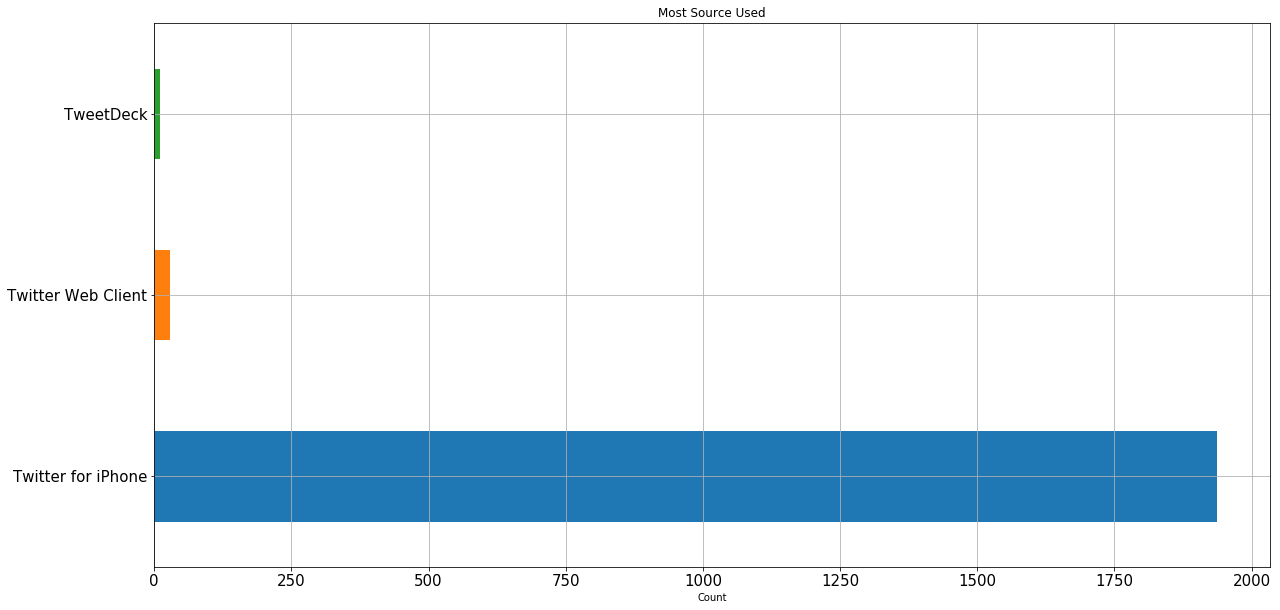

In [79]:
temp_df = f_df['source'].value_counts()

temp_df.plot(kind='barh', figsize=(20,10),grid=True, fontsize =15,
             title = 'Most Source Used').set_xlabel('Count')
 
plt.show()

### 2. Show number of tweets over time 

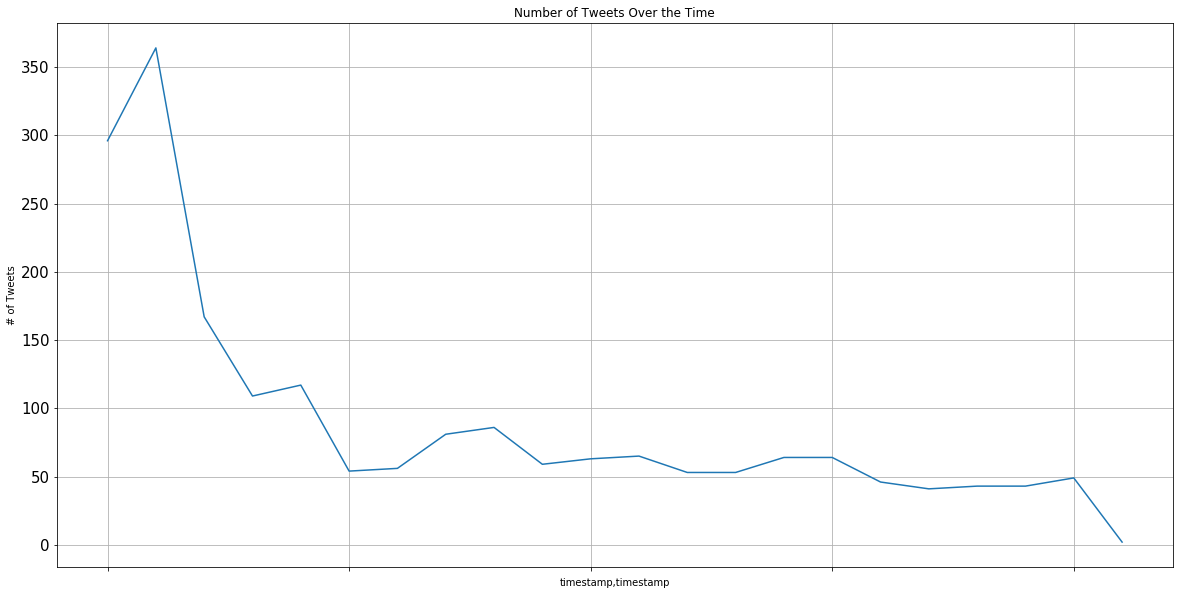

In [80]:
temp_df = f_df.tweet_id.groupby([f_df["timestamp"].dt.year, f_df["timestamp"].dt.month]).count()

temp_df.plot(kind='line', figsize=(20,10),grid=True, fontsize =15,
             title = 'Number of Tweets Over the Time').set_ylabel('# of Tweets')
 
plt.show()

### 3. Show top 10 comman dogs 

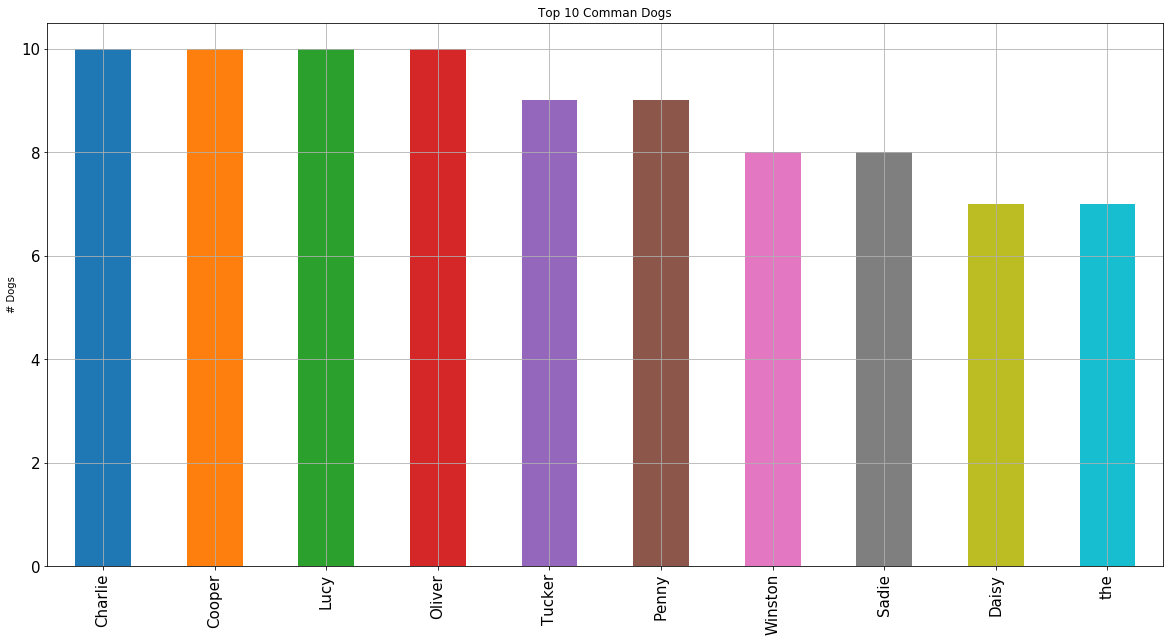

In [81]:
temp_df = f_df.name.value_counts()[1:11]

temp_df.plot(kind='bar', figsize=(20,10),grid=True, fontsize =15,
             title = 'Top 10 Comman Dogs').set_ylabel('# Dogs')
 
plt.show()